This is an example script for running the microcircuit model and generating basic plots of the network activity.

Import the necessary modules and start the time measurements.

In [1]:
import time
import nest
import network
import addons
import helpers
import numpy as np
import pandas as pd 
from network_params import net_dict
from sim_params import sim_dict
from stimulus_params import stim_dict

time_start = time.time()


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Apr 15 2024 07:21:32

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



Initialize the network with simulation, network and stimulation parameters, then create and connect all nodes, and finally simulate. The times for a presimulation and the main simulation are taken independently. A presimulation is useful because the spike activity typically exhibits a startup transient. In benchmark simulations, this transient should be excluded from a time measurement of the state propagation phase. Besides, statistical measures of the spike activity should only be computed after the transient has passed.

In [2]:
net = network.Network(sim_dict, net_dict, stim_dict)
time_network = time.time()

net.create()
time_create = time.time()

Data will be written to: /home/hyc_1/CorticalColumn_Github_2/CorticalColumn_Attempts/data_og/
  Directory already existed. Old data will be overwritten.


RNG seed: 55
Total number of virtual processes: 24
Creating neuronal populations.

Nov 27 16:40:40 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Creating recording devices.
  Creating spike recorders.
  Creating voltmeters.
Creating ammeters.
Creating ammeters.
Creating Poisson generators for background input.


In [3]:
net.connect()
time_connect = time.time()

Connecting neuronal populations recurrently.
Connecting Poisson generators for background input.

Nov 27 16:41:12 NodeManager::prepare_nodes [Info]: 
    Preparing 78129 nodes for simulation.


In [4]:
### Let's attempt to get the number of connections that go into the first 500 neurons of each population
data_synapses = addons.number_synapses(net.pops)

 pop: 0 
 pop: 1  50 
 pop: 2  20733 
 pop: 3  26567 
 pop: 4  48482 
 pop: 5  53961 
 pop: 6  58811 
 pop: 7  59876 
 neuron: 74271 

In [5]:
net.simulate(sim_dict["t_presim"])
time_presimulate = time.time()

Simulating 500.0 ms.

Nov 27 16:42:42 NodeManager::prepare_nodes [Info]: 
    Preparing 78129 nodes for simulation.

Nov 27 16:42:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 78129
    Simulation time (ms): 500
    Number of OpenMP threads: 24
    Number of MPI processes: 1

Nov 27 16:43:07 SimulationManager::run [Info]: 
    Simulation finished.


In [6]:
net.simulate(sim_dict["t_sim"])
time_simulate = time.time()

Simulating 3500.0 ms.

Nov 27 16:43:07 NodeManager::prepare_nodes [Info]: 
    Preparing 78129 nodes for simulation.

Nov 27 16:43:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 78129
    Simulation time (ms): 3500
    Number of OpenMP threads: 24
    Number of MPI processes: 1

Nov 27 16:46:41 SimulationManager::run [Info]: 
    Simulation finished.


Plot a spike raster of the simulated neurons and a box plot of the firing rates for each population. For visual purposes only, spikes 100 ms before and 100 ms after the thalamic stimulus time are plotted here by default. The computation of spike rates discards the presimulation time to exclude initialization artifacts.

Interval to plot spikes: [1000 1200] ms


ValueError: `bins` must be positive, when an integer

/usr/lib/python3/dist-packages/matplotlib/ticker.py:2788: RuntimeWarning:invalid value encountered in log10


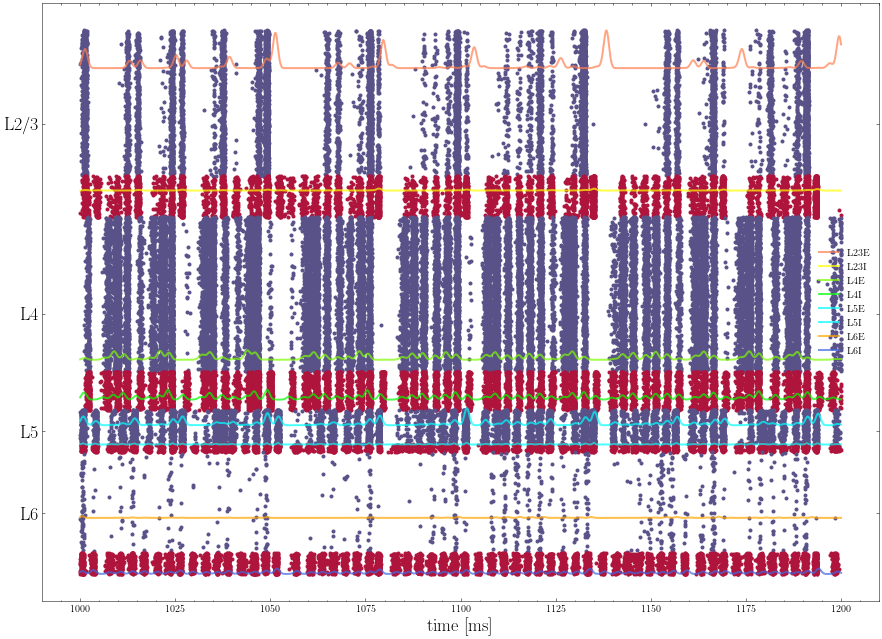

In [7]:
raster_plot_interval = np.array([1000, 1200])
firing_rates_interval = np.array([1000,2500])
pop_activity = net.evaluate(raster_plot_interval, firing_rates_interval,binned=True)
time_evaluate = time.time()

In [ ]:
from scipy.fft import fft
from scipy.fft import fftfreq
from scipy import signal
import matplotlib.pyplot as plt 

FFT_Results = {}
Welsh_Freqs = {}
Welsh_Powers = {}

for i in pop_activity:
    FFT_Results[i] = fft(pop_activity[i][analysis_interval_start:analysis_interval_end]-np.mean(pop_activity[i][analysis_interval_start:analysis_interval_end]))
    Welsh_Freqs[i], Welsh_Powers[i]  = signal.welch(pop_activity[i][analysis_interval_start:analysis_interval_end]-np.mean(pop_activity[i][analysis_interval_start:analysis_interval_end]),fs=500)

#Calcular los valores de frequencia correspondientes
freq = fftfreq(len(pop_activity[0][analysis_interval_start:analysis_interval_end]),d=0.002)
plt.figure(figsize=(15, 5))
colors = ['darkred', 'red', 'blue', 'aqua', 'green', 'lime', 'orange', 'moccasin']
# Graficar la amplitud en función de la frecuencia
plt.subplot(1, 3, 1)
j= 0

indx = int(len(pop_activity[0][analysis_interval_start:analysis_interval_end])/2)
for i in FFT_Results:
    plt.plot(freq[:indx], np.abs(FFT_Results[i])[:indx],c = colors[j], label = i)
    j=j+1
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Voltage (minus the mean) FFT')
plt.grid(True)
plt.xlim(1,90)

plt.legend(loc= 'best')

plt.subplot(1, 3, 2)
j= 0
indx = int(len(pop_activity[i][analysis_interval_start:analysis_interval_end])/2)
for i in FFT_Results:
    plt.plot(freq[:indx], 20 * np.log10(np.abs(FFT_Results[i])[:indx]),c = colors[j], label = i)
    j=j+1
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.title('Voltage (minus the mean) FFT')
plt.grid(True)
plt.xlim(1,100)
plt.ylim(-20,120)
plt.legend(loc= 'best')

plt.subplot(1, 3, 3)
j= 0

#plt.ylim([0.5e-3, 1])
for i in Welsh_Freqs:
    plt.plot(Welsh_Freqs[i], Welsh_Powers[i],c = colors[j], label = i)
    j=j+1
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'PSD $[V^2/Hz]$')
plt.title('Voltage (minus the mean) Welsh')
plt.grid(True)
plt.legend(loc= 'best')
plt.xlim(0,90)
plt.yscale('log')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
pops = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]
for i in pop_activity:
    plt.plot(pop_activity[i],label=pops[i])
plt.legend()
plt.xlim(1000,1500)

In [ ]:
voltage_data = addons.load_voltage("data_og/","voltmeter")
time_data = addons.get_time(voltage_data,net.num_neurons[0]) 
data_pop = {}
ex_current_pop = {}
in_current_pop = {}

for i in range(len(net.num_neurons)):
    data_pop[i] = addons.split_voltage(voltage_data[i], net.num_neurons[i])

del(voltage_data)

In [ ]:
ex_current_data = addons.load_current("data_og/","ex_current")
for i in range(len(net.num_neurons)):
    ex_current_pop[i] = addons.split_current(ex_current_data[i], net.num_neurons[i])

del(ex_current_data)

In [ ]:
in_current_data = addons.load_current("data_og/","in_current")
for i in range(len(net.num_neurons)):
    in_current_pop[i] = addons.split_current(in_current_data[i], net.num_neurons[i])

del(in_current_data)

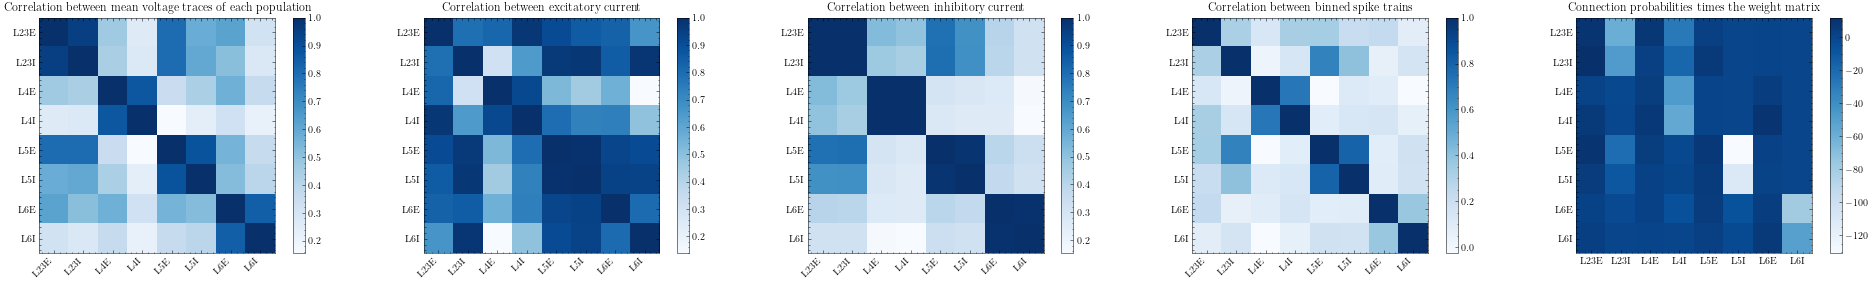

In [ ]:
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science'])

new_analysis_length = 10000
sd_names, node_ids, data = helpers.__load_spike_times("data_og/","spike_recorder",analysis_interval_start, analysis_interval_end)
times = {}
data_voltages = { }
data_excitatory = {}
data_inhibitory = {}
data_times = {}
bins = {}

names = ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"]

connection_p =np.array([[0.1009, 0.1689, 0.0437, 0.0818, 0.0323, 0.0, 0.0076, 0.0],
            [0.1346, 0.1371, 0.0316, 0.0515, 0.0755, 0.0, 0.0042, 0.0],
            [0.0077, 0.0059, 0.0497, 0.135, 0.0067, 0.0003, 0.0453, 0.0],
            [0.0691, 0.0029, 0.0794, 0.1597, 0.0033, 0.0, 0.1057, 0.0],
            [0.1004, 0.0622, 0.0505, 0.0057, 0.0831, 0.3726, 0.0204, 0.0],
            [0.0548, 0.0269, 0.0257, 0.0022, 0.06, 0.3158, 0.0086, 0.0],
            [0.0156, 0.0066, 0.0211, 0.0166, 0.0572, 0.0197, 0.0396, 0.2252],
            [0.0364, 0.001, 0.0034, 0.0005, 0.0277, 0.008, 0.0658, 0.1443],
        ]
    )

for i in range(len(data_pop)):
    random.shuffle(data_pop[i])
    random.shuffle(ex_current_pop[i])
    random.shuffle(in_current_pop[i])
    data_voltages[names[i]] =  np.mean(data_pop[i][0:1000],axis=0)
    data_excitatory[names[i]] = np.mean(ex_current_pop[i][0:1000],axis=0)
    data_inhibitory[names[i]] = np.mean(in_current_pop[i][0:1000],axis=0)
    neurons = np.unique(data[i]["sender"]) 
    random.shuffle(neurons)
    chosen_ones = neurons[1:1000]
    indices = []
    for indx in chosen_ones:
        indices = np.append(indices,np.where(data[i]["sender"]==indx))
    indices = np.array(indices,dtype=int)
    times_help = data[i][indices]["time_ms"] 
    times[names[i]], bins[names[i]] = np.histogram(data[i][indices]["time_ms"], bins = int(new_analysis_length/3))

dataframe = pd.DataFrame(data=data_voltages, columns= ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"])
matrix = dataframe.corr(method='pearson')

dataframe_ex = pd.DataFrame(data=data_excitatory, columns= ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"])
matrix_ex = dataframe_ex.corr(method='pearson')

dataframe_in = pd.DataFrame(data=data_inhibitory, columns= ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"])
matrix_in = dataframe_in.corr(method='pearson')

dataframe_times = pd.DataFrame(data=times, columns= ["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"])
matrix_times = dataframe_times.corr(method='pearson')

variables = []
for i in matrix.columns:
    variables.append(i)

variablest = []
for i in matrix_times.columns:
    variablest.append(i)

variables_ex = []
for i in matrix_ex.columns:
    variables_ex.append(i)

variables_in = []
for i in matrix_in.columns:
    variables_in.append(i)

plt.figure(figsize=(27,4))

# Adding labels to the matrix
plt.subplot(1, 5, 1)
plt.imshow(matrix, cmap='Blues')
plt.colorbar()
plt.title('Correlation between mean voltage traces of each population')
plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
plt.yticks(range(len(matrix)), variables)

plt.subplot(1, 5, 2)
plt.imshow(matrix_ex, cmap='Blues')
plt.colorbar()
plt.title('Correlation between excitatory current')
plt.xticks(range(len(matrix_ex)), variables_ex, rotation=45, ha='right')
plt.yticks(range(len(matrix_ex)), variables_ex)

plt.subplot(1, 5, 3)
plt.imshow(matrix_in, cmap='Blues')
plt.colorbar()
plt.title('Correlation between inhibitory current')
plt.xticks(range(len(matrix_in)), variables_in, rotation=45, ha='right')
plt.yticks(range(len(matrix_in)), variables_in)

plt.subplot(1, 5, 4)
plt.imshow(matrix_times, cmap='Blues')
plt.colorbar()
plt.title('Correlation between binned spike trains')
plt.xticks(range(len(matrix_times)), variablest, rotation=45, ha='right')
plt.yticks(range(len(matrix_times)), variablest)

plt.subplot(1, 5, 5)
plt.imshow(net.weight_matrix_mean * connection_p, cmap = 'Blues')
plt.xticks(ticks=[0,1,2,3,4,5,6,7],labels=["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"])
plt.yticks(ticks=[0,1,2,3,4,5,6,7],labels=["L23E", "L23I", "L4E", "L4I", "L5E", "L5I", "L6E", "L6I"])
plt.title('Connection probabilities times the weight matrix')
plt.colorbar()
plt.tight_layout()


In [ ]:
matrix.to_csv(name+'voltage_correlation.dat', sep=' ')
matrix_times.to_csv(name+ 'spiketimes_correlation.dat', sep=' ')


In [ ]:
for data in data_voltages:
    np.savetxt(name + 'data_voltages_'+str(data)+'.dat',data_voltages[i])
    np.savetxt(name + 'data_pops/data_times_'+str(data)+'.dat',times[i])
    np.savetxt(name + 'data_pops/data_bins_'+str(data)+'.dat',bins[i])

### Cross-correlation

Text(0, 0.5, 'Normalised correlation')

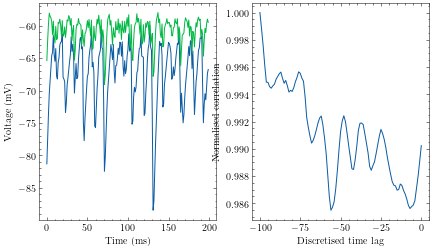

In [ ]:
from scipy import signal

f_corr = 4000
f_corr_end = 4200

corr = signal.correlate(data_voltages["L5E"][f_corr:f_corr_end],data_voltages["L23E"][f_corr-50:f_corr_end+50],mode='valid')
lags = signal.correlation_lags(len(data_voltages["L23E"][f_corr:f_corr_end]), len(data_voltages["L4I"][f_corr-50:f_corr_end+50]),mode='valid')
corr /= np.max(corr)
plt.figure(figsize=(7,4))
plt.subplot(1,2,1)
plt.plot(data_voltages["L23E"][f_corr:f_corr_end])
plt.plot(data_voltages["L4I"][f_corr:f_corr_end])
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.subplot(1,2,2)
plt.plot(lags, corr)
plt.xlabel("Discretised time lag")
plt.ylabel("Normalised correlation")


Text(0, 0.5, 'Normalised correlation')

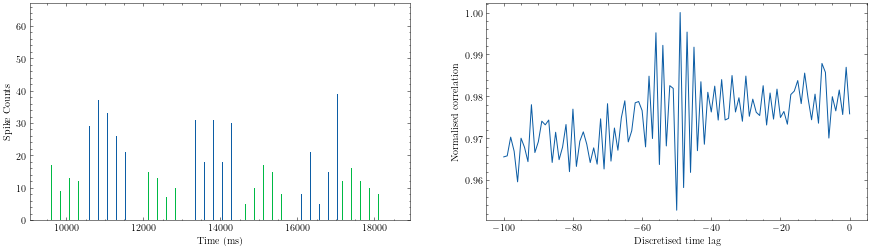

In [ ]:
from scipy import signal
f_corr = 500
f_corr_end = 1000

signal_1 = "L23E"
signal_2 = "L6E"

corr = np.array(signal.correlate(times[signal_1][f_corr:f_corr_end],times[signal_2][f_corr-50:f_corr_end+50],mode='valid'),dtype=float)
lags = signal.correlation_lags(len(times[signal_1][f_corr:f_corr_end]), len(times[signal_2][f_corr-50:f_corr_end+50]),mode='valid')
corr /= np.max(corr)
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.bar(bins[signal_1][f_corr:f_corr_end],times[signal_1][f_corr:f_corr_end])
plt.bar(bins[signal_2][f_corr:f_corr_end],times[signal_2][f_corr:f_corr_end])
plt.xlabel("Time (ms)")
plt.ylabel("Spike Counts")
plt.subplot(1,2,2)
plt.plot(lags, corr)
plt.xlabel("Discretised time lag")
plt.ylabel("Normalised correlation")


An attempt at obtaining the cross-correlogram

Text(0, 0.5, 'Normalised correlation')

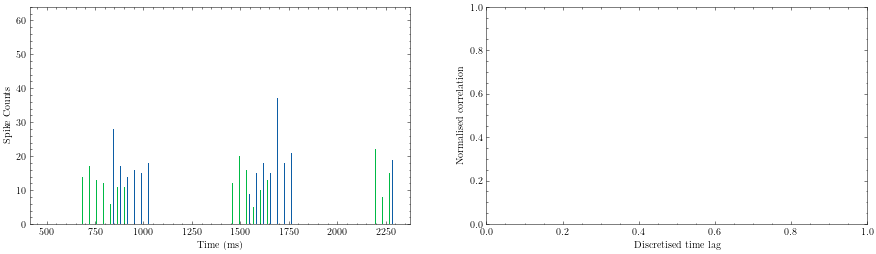

In [ ]:
from scipy import signal
f_corr = 0
f_corr_end = 100

signal_1 = "L23E"
signal_2 = "L6E"

spike_train_1 = times[signal_1][f_corr:f_corr_end]
spike_train_2 = times[signal_2][f_corr:f_corr_end]

bins_1 = bins[signal_1][f_corr:f_corr_end]
bins_2 = bins[signal_2][f_corr:f_corr_end]


lag_range = 20
coincidences = np.zeros(lag_range)

#for i in range(0,lag_range):
    

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.bar(bins_1,spike_train_1)
plt.bar(bins_2,spike_train_2)
plt.xlabel("Time (ms)")
plt.ylabel("Spike Counts")
plt.subplot(1,2,2)
#plt.plot(lags, corr)
plt.xlabel("Discretised time lag")
plt.ylabel("Normalised correlation")


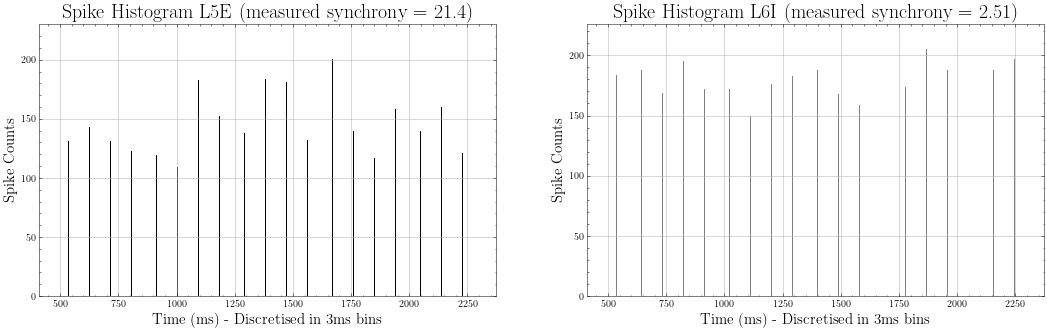

In [ ]:
from scipy import signal
f_corr = 0
f_corr_end = 100

signal_1 = "L5E"
signal_2 = "L6I"

plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.title('Spike Histogram L5E (measured synchrony = 21.4)', fontsize = 20)
plt.bar(bins[signal_1][f_corr:f_corr_end],times[signal_1][f_corr:f_corr_end], color = 'black')
plt.xlabel('Time (ms) - Discretised in 3ms bins', fontsize = 15)
plt.ylabel('Spike Counts', fontsize = 15)
plt.grid()
plt.subplot(1,2,2)
plt.title('Spike Histogram L6I (measured synchrony = 2.51)', fontsize = 20)
plt.bar(bins[signal_2][f_corr:f_corr_end],times[signal_2][f_corr:f_corr_end], color = 'grey')
plt.xlabel('Time (ms) - Discretised in 3ms bins', fontsize = 15)
plt.ylabel('Spike Counts', fontsize = 15)
plt.grid()



### Signal filtering

Fourier Transform

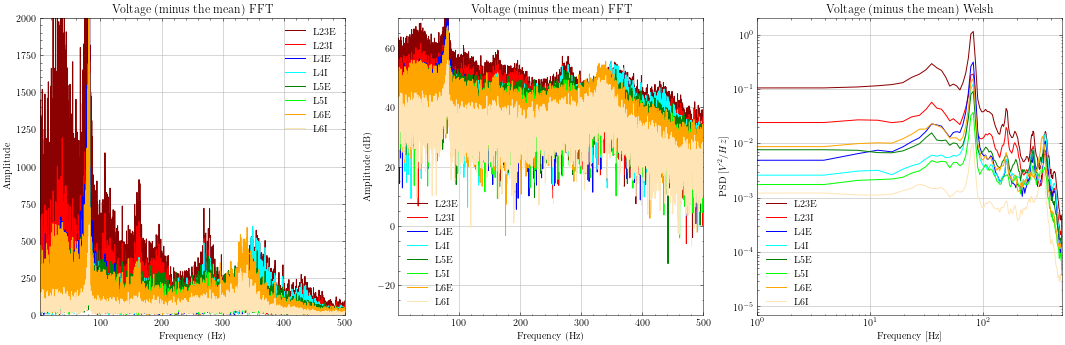

In [ ]:
from scipy.fft import fft
from scipy.fft import fftfreq
from scipy import signal


FFT_Results = {}
Welsh_Freqs = {}
Welsh_Powers = {}

for i in data_voltages:
    FFT_Results[i] = fft(data_voltages[i][analysis_interval_start:analysis_interval_end]-np.mean(data_voltages[i][analysis_interval_start:analysis_interval_end]))
    Welsh_Freqs[i], Welsh_Powers[i]  = signal.welch(data_voltages[i][analysis_interval_start:analysis_interval_end]-np.mean(data_voltages[i][analysis_interval_start:analysis_interval_end]),fs=1000)

#Calcular los valores de frequencia correspondientes
freq = fftfreq(len(data_voltages["L23E"][analysis_interval_start:analysis_interval_end]),d=0.001)
plt.figure(figsize=(15, 5))
colors = ['darkred', 'red', 'blue', 'aqua', 'green', 'lime', 'orange', 'moccasin']
# Graficar la amplitud en función de la frecuencia
plt.subplot(1, 3, 1)
j= 0

indx = int(len(data_voltages[i][analysis_interval_start:analysis_interval_end])/2)
for i in FFT_Results:
    plt.plot(freq[:indx], np.abs(FFT_Results[i])[:indx],c = colors[j], label = i)
    j=j+1
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Voltage (minus the mean) FFT')
plt.grid(True)
plt.xlim(1,500)
plt.ylim(0,2000)
plt.legend(loc= 'best')

plt.subplot(1, 3, 2)
j= 0
indx = int(len(data_voltages[i][analysis_interval_start:analysis_interval_end])/2)
for i in FFT_Results:
    plt.plot(freq[:indx], 20 * np.log10(np.abs(FFT_Results[i])[:indx]),c = colors[j], label = i)
    j=j+1
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.title('Voltage (minus the mean) FFT')
plt.grid(True)
plt.xlim(1,500)
plt.ylim(-30,70)
plt.legend(loc= 'best')

plt.subplot(1, 3, 3)
j= 0

#plt.ylim([0.5e-3, 1])
for i in Welsh_Freqs:
    plt.plot(Welsh_Freqs[i], Welsh_Powers[i],c = colors[j], label = i)
    j=j+1
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'PSD $[V^2/Hz]$')
plt.title('Voltage (minus the mean) Welsh')
plt.grid(True)
plt.legend(loc= 'best')
plt.tight_layout()
plt.xlim(1,500)
plt.xscale('log')
plt.yscale('log')
plt.show()


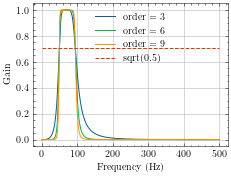

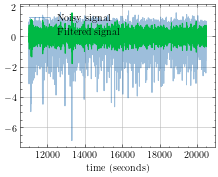

In [ ]:
from scipy.signal import butter, lfilter
from scipy.signal import freqz

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Sample rate and desired cutoff frequencies (in Hz).
fs = 1000
lowcut = 50
highcut = 95
times = time_data

#gamma: 50 95
#alpha: 8 12

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, fs=fs, worN=2000)
    plt.plot(w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
#plt.xlim(0,20)
plt.grid(True)
plt.legend(loc='best')

# Filter a noisy signal.
plt.figure(2)
plt.clf()
plt.plot(times[analysis_interval_start:analysis_interval_end], data_voltages[i][analysis_interval_start:analysis_interval_end]-np.mean(data_voltages[i][analysis_interval_start:analysis_interval_end]), label='Noisy signal',alpha=0.4)

y = butter_bandpass_filter(data_voltages[i][analysis_interval_start:analysis_interval_end]-np.mean(data_voltages[i][analysis_interval_start:analysis_interval_end]), lowcut, highcut, fs, order=3)
plt.plot(times[analysis_interval_start:analysis_interval_end], y, label='Filtered signal ')
plt.xlabel('time (seconds)')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')


plt.show()

In [ ]:
filtered_alpha = {}
filtered_gamma = {}

for i in data_voltages:
    fs = 1000
    lowcut_gamma = 50
    highcut_gamma = 95
    filtered_gamma[i] = butter_bandpass_filter(data_voltages[i][analysis_interval_start:analysis_interval_end]-np.mean(data_voltages[i][analysis_interval_start:analysis_interval_end]), lowcut_gamma, highcut_gamma, fs, order=3)

    lowcut_alpha = 8
    highcut_alpha = 12
    filtered_alpha[i] = butter_bandpass_filter(data_voltages[i][analysis_interval_start:analysis_interval_end]-np.mean(data_voltages[i][analysis_interval_start:analysis_interval_end]), lowcut_alpha, highcut_alpha, fs, order=3)


In [ ]:
from scipy.optimize import curve_fit

def gaus(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

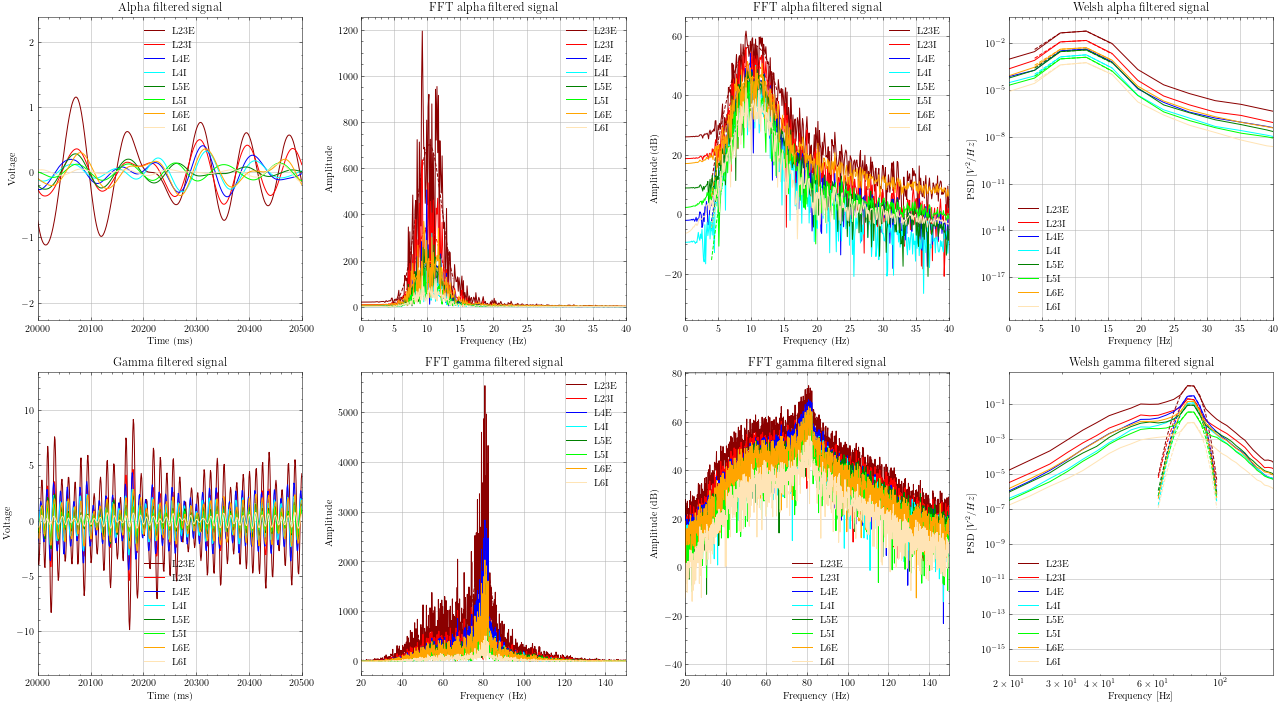

In [ ]:
FFT_Results_alpha = {}
FFT_Results_gamma = {}
Welsh_Freqs_alpha = {}
Welsh_Powers_alpha = {}
Welsh_Freqs_gamma = {}
Welsh_Powers_gamma = {}

Fit_FFT_alpha = {}
Fit_Welsh_alpha = {}
mean_freq_alfa = []
mean_welsh_alfa = []
amplitude_freq_alfa = []
amplitude_welsh_alfa = []
sigma_freq_alfa = []
sigma_welsh_alfa = []

Fit_FFT_gamma = {}
Fit_Welsh_gamma = {}
mean_freq_gamma = {}
mean_welsh_gamma = {}
mean_freq_gamma = []
mean_welsh_gamma = []
amplitude_freq_gamma = []
amplitude_welsh_gamma = []
sigma_freq_gamma = []
sigma_welsh_gamma = []

for i in data_voltages:
    FFT_Results_alpha[i] = fft(filtered_alpha[i][analysis_interval_start:analysis_interval_end])
    FFT_Results_gamma[i] = fft(filtered_gamma[i][analysis_interval_start:analysis_interval_end])
    Welsh_Freqs_alpha[i], Welsh_Powers_alpha[i]  = signal.welch(filtered_alpha[i][analysis_interval_start:analysis_interval_end],fs=1000)
    Welsh_Freqs_gamma[i], Welsh_Powers_gamma[i]  = signal.welch(filtered_gamma[i][analysis_interval_start:analysis_interval_end],fs=1000)


#Calcular los valores de frequencia correspondientes
freq = fftfreq(len(filtered_gamma["L23E"][analysis_interval_start:analysis_interval_end]),d=0.001)
colors = ['darkred', 'red', 'blue', 'aqua', 'green', 'lime', 'orange', 'moccasin']
# Graficar la amplitud en función de la frecuencia
indx = int(len(filtered_gamma["L23E"][analysis_interval_start:analysis_interval_end])/2)


index_alpha_start = int(np.where(freq==4.0)[0][0])
index_alpha_end = int(np.where(freq==14.0)[0][0])



index_gamma_start = int(np.where(freq==70.0)[0][0])
index_gamma_end = int(np.where(freq==90.0)[0][0])

plt.figure(figsize=(18,10))


plt.subplot(2, 4, 1)
j= 0
for i in filtered_alpha:
    plt.plot(times[analysis_interval_start+500:analysis_interval_end],filtered_alpha[i][analysis_interval_start:analysis_interval_end], c = colors[j], label = i)
    j=j+1
plt.xlabel('Time (ms)')
plt.ylabel('Voltage')
plt.title('Alpha filtered signal')
plt.xlim(20000,20500)
plt.grid(True)
plt.legend(loc= 'best')

# Adding labels to the matrix
plt.subplot(2, 4, 2)
j= 0
for i in FFT_Results_alpha:
    Fit_FFT_alpha[i], __ = curve_fit(gaus,freq[index_alpha_start:index_alpha_end],np.abs(FFT_Results_alpha[i][index_alpha_start:index_alpha_end]),p0 = [30,10,5])
    mean_freq_alfa = np.append(mean_freq_alfa,Fit_FFT_alpha[i][1])
    amplitude_freq_alfa = np.append(amplitude_freq_alfa,Fit_FFT_alpha[i][0])
    sigma_freq_alfa = np.append(sigma_freq_alfa,Fit_FFT_alpha[i][2])

    plt.plot(freq[:indx], np.abs(FFT_Results_alpha[i])[:indx],c = colors[j], label = i)
    plt.plot(freq[index_alpha_start:index_alpha_end],gaus(freq[index_alpha_start:index_alpha_end],*Fit_FFT_alpha[i]),'--', c = colors[j])
    j=j+1
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT alpha filtered signal')
plt.grid(True)
plt.legend(loc= 'best')
plt.xlim(0,40)

plt.subplot(2, 4, 3)
j= 0
for i in FFT_Results_alpha:
    plt.plot(freq[:indx], 20 * np.log10(np.abs(FFT_Results_alpha[i])[:indx]),c = colors[j], label = i)
    plt.plot(freq[index_alpha_start:index_alpha_end],20 * np.log10(gaus(freq[index_alpha_start:index_alpha_end],*Fit_FFT_alpha[i])),'--', c = colors[j])
    j=j+1
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.title('FFT alpha filtered signal')
plt.grid(True)
plt.legend(loc= 'best')
plt.xlim(0,40)

plt.subplot(2, 4, 4)
j= 0
for i in Welsh_Freqs_alpha:
    i_start = int(np.where((Welsh_Freqs_alpha[i] < 4) & (Welsh_Freqs_alpha[i] > 0.0))[0][0])
    i_end = int(np.where((Welsh_Freqs_alpha[i]<22.0) & (Welsh_Freqs_alpha[i] >18.0))[0][0])

    Fit_Welsh_alpha[i], __ = curve_fit(gaus,Welsh_Freqs_alpha[i][i_start:i_end],Welsh_Powers_alpha[i][i_start:i_end],p0 = [0.01,10,5])
    mean_welsh_alfa = np.append(mean_welsh_alfa,Fit_Welsh_alpha[i][1])
    amplitude_welsh_alfa = np.append(amplitude_welsh_alfa,Fit_Welsh_alpha[i][0])
    sigma_welsh_alfa = np.append(sigma_welsh_alfa,Fit_Welsh_alpha[i][2])
    plt.plot(Welsh_Freqs_alpha[i], Welsh_Powers_alpha[i],c = colors[j], label = i)
    plt.plot(Welsh_Freqs_alpha[i][i_start:i_end],gaus(Welsh_Freqs_alpha[i][i_start:i_end],*Fit_Welsh_alpha[i]),'--', c = colors[j])
    j=j+1
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'PSD $[V^2/Hz]$')
plt.title('Welsh alpha filtered signal')
plt.grid(True)
plt.legend(loc= 'best')
plt.xlim(0,40)
plt.yscale('log')

plt.subplot(2, 4, 5)
j= 0
for i in filtered_gamma:
    plt.plot(times[analysis_interval_start+500:analysis_interval_end],filtered_gamma[i][analysis_interval_start:analysis_interval_end], c = colors[j], label = i)
    j=j+1
plt.xlabel('Time (ms)')
plt.ylabel('Voltage')
plt.title('Gamma filtered signal')
plt.xlim(20000,20500)
plt.grid(True)
plt.legend(loc= 'best')


plt.subplot(2, 4, 6)
j=0
for i in FFT_Results_gamma:
    Fit_FFT_gamma[i], __ = curve_fit(gaus,freq[index_gamma_start:index_gamma_end],np.abs(FFT_Results_gamma[i][index_gamma_start:index_gamma_end]),p0 = [100,80,20])
    mean_freq_gamma = np.append(mean_freq_gamma,Fit_FFT_gamma[i][1])
    amplitude_freq_gamma = np.append(amplitude_freq_gamma,Fit_FFT_gamma[i][0])
    sigma_freq_gamma = np.append(sigma_freq_gamma,Fit_FFT_gamma[i][2])
    plt.plot(freq[:indx], np.abs(FFT_Results_gamma[i])[:indx],c = colors[j], label = i)
    plt.plot(freq[index_gamma_start:index_gamma_end],gaus(freq[index_gamma_start:index_gamma_end],*Fit_FFT_gamma[i]),'--', c = colors[j])
    j=j+1
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT gamma filtered signal')
plt.xlim(20,150)
plt.grid(True)
plt.legend(loc= 'best')

plt.subplot(2, 4, 7)
j= 0
for i in FFT_Results_gamma:
    plt.plot(freq[:indx], 20 * np.log10(np.abs(FFT_Results_gamma[i])[:indx]),c = colors[j], label = i)
    plt.plot(freq[index_gamma_start:index_gamma_end],20 * np.log10(gaus(freq[index_gamma_start:index_gamma_end],*Fit_FFT_gamma[i])),'--', c = colors[j])
    j=j+1
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.title('FFT gamma filtered signal')
plt.grid(True)
plt.legend(loc= 'best')
plt.xlim(20,150)

plt.subplot(2, 4, 8)
j= 0
for i in Welsh_Freqs_gamma:
    i_start = int(np.where((Welsh_Freqs_alpha[i] < 70) & (Welsh_Freqs_alpha[i] > 60.0))[0][0])
    i_end = int(np.where((Welsh_Freqs_alpha[i]<150.0) & (Welsh_Freqs_alpha[i] >100.0))[0][0])
    
    Fit_Welsh_gamma[i], __ = curve_fit(gaus,Welsh_Freqs_gamma[i][i_start:i_end],Welsh_Powers_gamma[i][i_start:i_end],p0 = [1,80,10])
    mean_welsh_gamma = np.append(mean_welsh_gamma,Fit_Welsh_gamma[i][1])
    amplitude_welsh_gamma = np.append(amplitude_welsh_gamma,Fit_Welsh_gamma[i][0])
    sigma_welsh_gamma = np.append(sigma_welsh_gamma,Fit_Welsh_gamma[i][2])

    plt.plot(Welsh_Freqs_gamma[i], Welsh_Powers_gamma[i],c = colors[j], label = i)
    plt.plot(Welsh_Freqs_gamma[i][i_start:i_end],gaus(Welsh_Freqs_gamma[i][i_start:i_end],*Fit_Welsh_gamma[i]),'--', c = colors[j])
    j=j+1
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'PSD $[V^2/Hz]$')
plt.title('Welsh gamma filtered signal')
plt.grid(True)
plt.legend(loc= 'best')
plt.xlim(20,150)
plt.xscale('log')
plt.yscale('log')


plt.tight_layout()
plt.show()

In [ ]:
mean_final_alpha = np.mean( np.array([mean_freq_alfa,mean_welsh_alfa]),axis= 0)
mean_final_gamma = np.mean( np.array([mean_freq_gamma,mean_welsh_gamma]),axis= 0)

amplitude_final_alpha = np.mean( np.array([amplitude_freq_alfa,amplitude_welsh_alfa]),axis= 0)
amplitude_final_gamma = np.mean( np.array([amplitude_freq_gamma,amplitude_welsh_gamma]),axis= 0)

sigma_final_alpha = np.mean( np.array([sigma_freq_alfa,sigma_welsh_alfa]),axis= 0)
sigma_final_gamma = np.mean( np.array([sigma_freq_gamma,mean_welsh_gamma]),axis= 0)
pops = [0,1,2,3,4,5,6,7]


np.savetxt(name + 'freq.dat', np.c_[pops,mean_final_alpha, amplitude_final_alpha, sigma_final_alpha, mean_final_gamma, amplitude_final_gamma, sigma_final_gamma], fmt = '%.2f', header = 'Pops mean_freq_alpha amplitude sigma mean_freq_gamma amplitude sigma')